In [116]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tqdm import tqdm

In [117]:
def _pos_encoding(t, output_dim, device='cpu'):
  D = output_dim
  v = torch.zeros(D, device=device)

  i = torch.arange(0, D, device=device)
  div_term = 10000 ** (i / D)

  v[0::2] = torch.sin(t / div_term[0::2])
  v[1::2] = torch.cos(t / div_term[1::2])
  return v

In [118]:
v = _pos_encoding(1, 16)
print(v.shape)

torch.Size([16])


In [119]:
def pos_encoding(ts, output_dim, device='cpu'):
  batch_size = len(ts)
  v = torch.zeros(batch_size, output_dim, device=device)
  for i in range(batch_size):
    v[i] = _pos_encoding(ts[i], output_dim, device)
  return v

In [120]:
v = pos_encoding(torch.tensor([1, 2, 3]), 16)
print(v.shape)

torch.Size([3, 16])


In [121]:
class ConvBlock(nn.Module):
  def __init__(self, in_ch, out_ch, time_embed_dim):
    super().__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU()
    )
    self.mlp = nn.Sequential(
        nn.Linear(time_embed_dim, in_ch),
        nn.ReLU(),
        nn.Linear(in_ch, in_ch)
    )

  def forward(self, x, v):
    N, C, _, _ = x.shape
    v = self.mlp(v)
    v = v.view(N, C, 1, 1)
    y = self.convs(x + v)
    return y

In [122]:
class UNet(nn.Module):
  def __init__(self, in_ch=1, time_embed_dim=100):
    super().__init__()

    self.time_embed_dim = time_embed_dim

    self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
    self.down2 = ConvBlock(64, 128, time_embed_dim)
    self.bot1 = ConvBlock(128, 256, time_embed_dim)
    self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
    self.up1 = ConvBlock(128 + 64, 64, time_embed_dim)
    self.out = nn.Conv2d(64, in_ch, 1)

    self.maxpool = nn.MaxPool2d(2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

  def forward(self, x, timesteps):
    # 사인파 위치 인코딩
    v = pos_encoding(timesteps, self.time_embed_dim, x.device)
    x1 = self.down1(x, v)  # 신경망에 v도 입력
    x = self.maxpool(x1)
    x2 = self.down2(x, v)
    x = self.maxpool(x2)

    x = self.bot1(x, v)

    x = self.upsample(x)
    x = torch.cat([x, x2], dim=1)
    x = self.up2(x, v)
    x = self.upsample(x)
    x = torch.cat([x, x1], dim=1)
    x = self.up1(x, v)
    x = self.out(x)
    return x

## 9.4 데이터 생성

In [123]:
class Diffuser:
  def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
    self.num_timesteps = num_timesteps
    self.device = device
    self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
    self.alphas = 1 - self.betas
    self.alpha_bars = torch.cumprod(self.alphas, dim=0)

  def add_noise(self, x_0, t):
    T = self.num_timesteps
    assert (t >= 1).all() and (t <= T).all()  # 모든 원소가 1~T 범위인지 확인

    t_idx = t - 1
    alpha_bar = self.alpha_bars[t_idx]
    N = alpha_bar.size(0)
    alpha_bar = alpha_bar.view(N, 1, 1, 1)  # alpha_bar의 형상 변환

    noise = torch.randn_like(x_0, device=self.device)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
    return x_t, noise

  # 노이즈 제거 처리 함수
  def denoise(self, model, x, t):
    # t의 모든 원소가 1~T 범위인지 확인
    T = self.num_timesteps
    assert (t >= 1).all() and (t <= T).all()

    t_idx = t - 1
    alpha = self.alphas[t_idx]
    alpha_bar = self.alpha_bars[t_idx]
    alpha_bar_prev = self.alpha_bars[t_idx-1]

    # 브로드캐스트가 올바르게 수행되도록 설정
    N = alpha.size(0)
    alpha = alpha.view(N, 1, 1, 1)
    alpha_bar = alpha_bar.view(N, 1, 1, 1)
    alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

    model.eval()           # 평가 모드로 전화
    with torch.no_grad():  # 기울기 계산 비활성화
      eps = model(x, t)
    model.train()          # 학습 모드로 전환

    noise = torch.randn_like(x, device=self.device)
    noise[t == 1] = 0

    mu = (x - ((1-alpha) / torch.sqrt(1-alpha_bar)) * eps) / torch.sqrt(alpha)
    std = torch.sqrt((1-alpha) * (1-alpha_bar_prev) / (1-alpha_bar))
    return mu + noise * std

  def reverse_to_img(self, x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    x = x.cpu()
    to_pil = transforms.ToPILImage()
    return to_pil(x)

  # 데이터 샘플 생성 함수
  def sample(self, model, x_shape=(20, 1, 28, 28)):
    batch_size = x_shape[0]
    x = torch.randn(x_shape, device=self.device)

    for i in tqdm(range(self.num_timesteps, 0, -1)):  # 역순으로 순환
      t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
      x = self.denoise(model, x, t)  # 노이즈 제거
    # 각 배치의 텐서들을 이미지로 변환
    images = [self.reverse_to_img(x[i]) for i in range(batch_size)]
    return images

## 9.5 확산 모델의 학습(구현)

In [124]:
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

In [125]:
# 하이퍼 파라미터
img_size = 28
batch_size = 128
num_timesteps = 1000
epochs = 10
lr = 1e-3
device = 'cuda'if torch.cuda.is_available() else 'cpu'

In [126]:
# 이미지 시각화 함수
def show_images(images, rows=2, cols= 10):
  fig = plt.figure(figsize=(cols, rows))
  i = 0
  for r in range(rows):
    for c in range(cols):
      fig.add_subplot(rows, cols, i + 1)
      plt.imshow(images[i], cmap='gray')
      plt.axis('off')  # 세로축과 가로축 숨기기
      i += 1
  plt.show()

In [127]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/DLFS5/data',
                                     download=True,
                                     transform=preprocess)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [128]:
diffuser = Diffuser(num_timesteps, device=device)
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=lr)

100%|██████████| 1000/1000 [00:11<00:00, 90.02it/s]


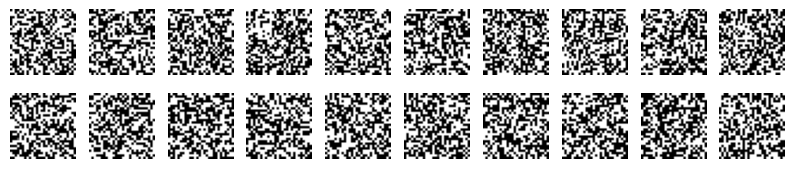

100%|██████████| 469/469 [00:56<00:00,  8.31it/s]


Epoch 0 | Loss: 0.044955512044081554


100%|██████████| 1000/1000 [00:10<00:00, 93.97it/s]


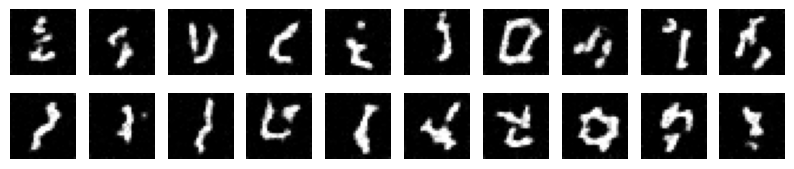

100%|██████████| 469/469 [00:56<00:00,  8.35it/s]


Epoch 1 | Loss: 0.026544829498904982


100%|██████████| 1000/1000 [00:10<00:00, 94.93it/s]


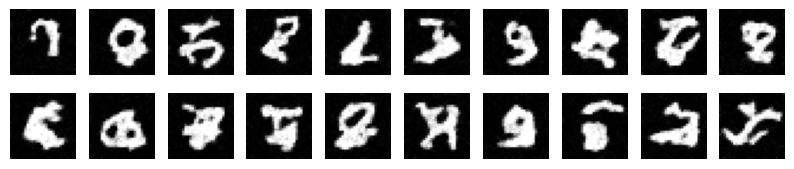

100%|██████████| 469/469 [00:57<00:00,  8.23it/s]


Epoch 2 | Loss: 0.02380694945785664


100%|██████████| 1000/1000 [00:10<00:00, 94.42it/s]


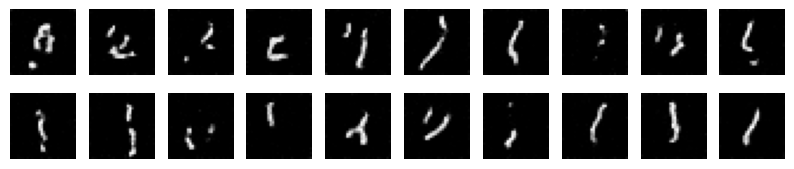

100%|██████████| 469/469 [00:56<00:00,  8.33it/s]


Epoch 3 | Loss: 0.021706914453745396


100%|██████████| 1000/1000 [00:10<00:00, 93.76it/s]


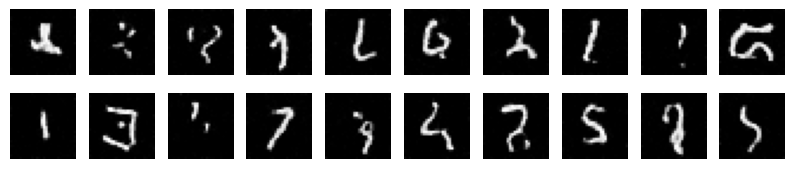

100%|██████████| 469/469 [00:56<00:00,  8.24it/s]


Epoch 4 | Loss: 0.020819550318552104


100%|██████████| 1000/1000 [00:10<00:00, 92.90it/s]


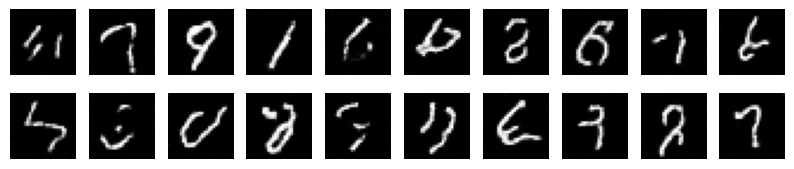

100%|██████████| 469/469 [00:57<00:00,  8.21it/s]


Epoch 5 | Loss: 0.019950506797652128


100%|██████████| 1000/1000 [00:10<00:00, 93.82it/s]


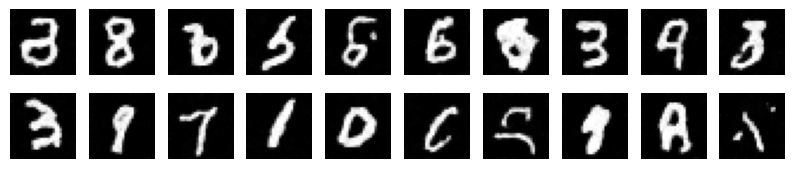

100%|██████████| 469/469 [00:58<00:00,  8.07it/s]


Epoch 6 | Loss: 0.019366322402983333


100%|██████████| 1000/1000 [00:10<00:00, 93.34it/s]


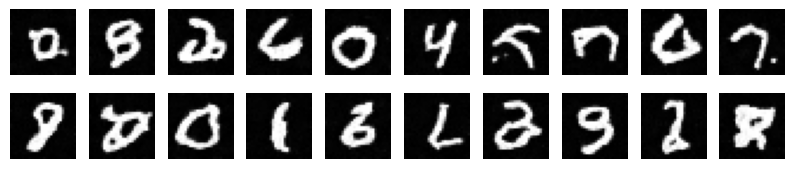

100%|██████████| 469/469 [00:57<00:00,  8.13it/s]


Epoch 7 | Loss: 0.0185021184809776


100%|██████████| 1000/1000 [00:10<00:00, 98.75it/s]


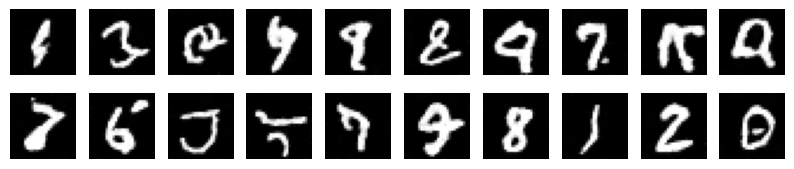

100%|██████████| 469/469 [00:57<00:00,  8.12it/s]


Epoch 8 | Loss: 0.018337660228837527


100%|██████████| 1000/1000 [00:10<00:00, 95.79it/s]


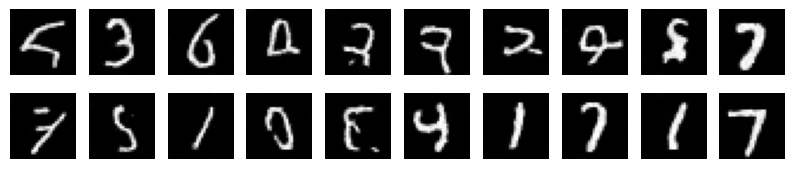

100%|██████████| 469/469 [00:57<00:00,  8.13it/s]

Epoch 9 | Loss: 0.01808598085340343


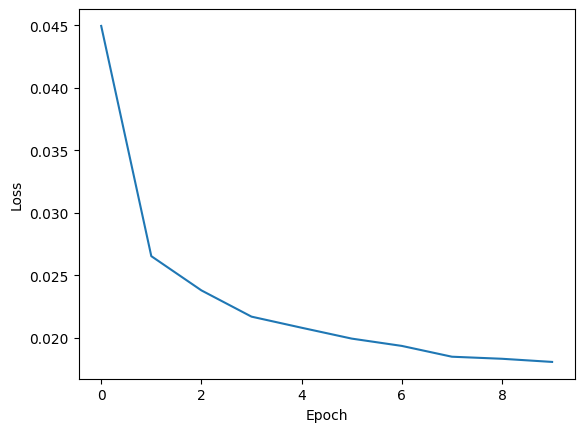

100%|██████████| 1000/1000 [00:10<00:00, 93.50it/s]


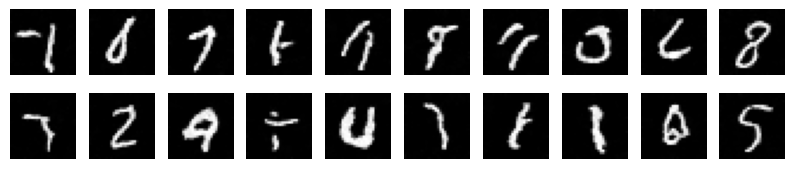

In [129]:
losses = []
for epoch in range(epochs):
  loss_sum = 0.0
  cnt = 0

  # 에포크마다 데이터를 생성하여 결과를 확인하고 싶다면 다음 주석을 해제
  images = diffuser.sample(model)
  show_images(images)

  for images, labels in tqdm(dataloader):  # 진행률 표시줄(tqdm) 사용
    optimizer.zero_grad()
    x = images.to(device)
    t = torch.randint(1, num_timesteps+1, (len(x),), device=device)

    x_noisy, noise = diffuser.add_noise(x, t)  # 시각 t의 노이즈 이미지 생성
    noise_pred = model(x_noisy, t)             # 모델로 노이즈 예측
    loss = F.mse_loss(noise, noise_pred)       # 실제 노이즈와의 제곱 오차 계산

    loss.backward()
    optimizer.step()

    loss_sum += loss.item()
    cnt += 1

  loss_avg = loss_sum / cnt
  losses.append(loss_avg)
  print(f'Epoch {epoch} | Loss: {loss_avg}')

# 손실 그래프
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 학습된 모델로 이미지 생성
images = diffuser.sample(model)
show_images(images)